## Rate of penetration prediction using regression models

#### Eldar Sharafutdinov
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin





_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive summary

The goal is to tackle the relationship between Rate of Penetration (ROP) and drilling regime parameters:

\begin{equation}
ROP = f(Hookload, WOB, RPM, Torque, StandpipePressure)
\end{equation}

Where:
* WOB - Weight on bit
* RPM - Revolution per minute

Data preprocessing and analysis has been performed. Random Forest model was proposed to be used as a regression model to predict ROP. Two cases of data split were performed and two regression models were built. It was found out that there is no linear relationship between target and predictor features. Random forest model results were quite bad, as the correlation between estimated and actual ROP was found to be 0.32, while MSE = 8.37. The more complex Gradient Boosting models didn't give much of improvement, however, the best prediction was the random split case with Gradient Boosting. Feature Importance analysis indicated a high impact of Standpipe pressure and WOB on ROP prediction.

### Short literature review

The first mathematical model was developed by [Maurer](https://onepetro.org/JPT/article/14/11/1270/162689/The-Perfect-Cleaning-Theory-of-Rotary-Drilling), which estimates ROP based on rock compressive strength, WOB, RPM and well diameter. Further, this model was improved by Bingham(M.G. Bingham / A new approach to interpreting rock drillability
Petroleum Publishing Company). However, both of these analytical representations do not consider the effect of formation compaction, bit hydraulics, differential pressure, and bit wear on ROP change. It is assumed that proper integration of the data in the model will help to estimate ROP more accurately, than analytical models do. 

### Import packages

In [1]:
import pandas as pd                                       # For working with data
import pandas.plotting as pd_plot
import numpy as np                                        # For working with data and model arrays
import matplotlib.pyplot as plt                           # Data visualization
import math                                               # Import math functions

from sklearn.ensemble import RandomForestRegressor        # Import Random Forest
from sklearn.ensemble import GradientBoostingRegressor    # Import Gradient Boosting
from sklearn.model_selection import train_test_split      # Train test data split
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score  # Import metrics

import warnings                                           # Warnings
warnings.filterwarnings('ignore')                         # Ignore warnings, which usually happens with Random Forest

### Declare functions

The following functions will be used in the workflow.

In [2]:
def plot_corr(dataframe,size=10):        # function from Professor Michael Pyrcz                 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0,cmap = plt.cm.bwr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

    
def plot_data(df, features):             # function from Professor Michael Pyrcz
    plt.subplot(231)
    plt.hist(df[features[0]], alpha = 0.5, color = 'orange', edgecolor = 'black', bins=20)
    plt.title('Hook_load, tonne');

    plt.subplot(232)
    plt.hist(df[features[1]], alpha = 0.5, color = 'orange', edgecolor = 'black', bins=20)
    plt.title('Weight on Bit, tonne');

    plt.subplot(233)
    plt.hist(df[features[2]], alpha = 0.5, color = 'orange', edgecolor = 'black', bins=20)
    plt.title('Revolution per minute, 1/min');

    plt.subplot(234)
    plt.hist(df[features[3]], alpha = 0.5, color = 'orange', edgecolor = 'black', bins=20)
    plt.title('Torque, kN*m');

    plt.subplot(235)
    plt.hist(df[features[4]], alpha = 0.5, color = 'orange', edgecolor = 'black', bins=20)
    plt.title('Intake_Pressure, bar');

    plt.subplot(236)
    plt.hist(df[features[5]], alpha = 0.5, color = 'orange', edgecolor = 'black', bins=20)
    plt.title('Rate of Penetration, m/h');

    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.2, wspace=0.15, hspace=0.15)
    plt.show()
    
    
def plot_data_as_EDR(df, features):
    plt.subplot(161)
    plt.plot(df[features[0]],df['MD'])   # Plot parameter
    plt.gca().invert_yaxis()             # Invert y axis
    plt.title('Hook Load'); plt.grid(); plt.ylabel('Depth, m'); plt.xlabel('Hook_load, tonne')
    
    plt.subplot(162)
    plt.plot(df[features[1]],df['MD'])
    plt.gca().invert_yaxis()
    plt.title('Weight on Bit'); plt.grid(); plt.xlabel('Weight on Bit, tonne')
                
    plt.subplot(163)
    plt.plot(df[features[2]],df['MD'])
    plt.gca().invert_yaxis()
    plt.title('Revolution per minute'); plt.grid(); plt.xlabel('Revolution per minute, 1/min')
    
    plt.subplot(164)
    plt.plot(df[features[3]],df['MD'])
    plt.gca().invert_yaxis()
    plt.title('Torque'); plt.grid(); plt.xlabel('Torque, kN*m')
    
    plt.subplot(165)
    plt.plot(df[features[4]],df['MD'])
    plt.gca().invert_yaxis()
    plt.title('Intake_Pressure'); plt.grid(); plt.xlabel('Intake_Pressure, bar')

    plt.subplot(166)
    plt.plot(df[features[5]],df['MD'])
    plt.gca().invert_yaxis()
    plt.title('Rate of Penetration'); plt.grid(); plt.xlabel('Rate of Penetration, m/h')
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.2, wspace=0.25, hspace=0.15)
    plt.show()
    
    
def random_forest(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor()   # instantiate the random forest  
    rf = rf.fit(X_train, y_train) # fit the random forest

    prediction = rf.predict(X_test).reshape(-1,1)  #1d array convert to 2d
    MSE = mean_squared_error(y_test, prediction)
    Var_Exp = explained_variance_score(y_test, prediction)
    R2 = r2_score(y_test, prediction)
    corr = math.sqrt(abs(R2))
    error = prediction-y_test.values
    mean = np.mean(error)
    std = np.std(error)
    
    return rf, prediction, MSE, Var_Exp, R2, corr, error, mean, std


def boosting(X_train, X_test, y_train, y_test, max_depth, learning_rate, num_tree):
    params = {
        'loss': 'ls',                         
        'max_depth': max_depth,                 
        'learning_rate': learning_rate,
        'criterion': 'mse'                 
    }

    boosting_model = GradientBoostingRegressor(n_estimators=int(num_tree),**params)
    boosting_model.fit(X_train,y_train)
    prediction = boosting_model.predict(X_test).reshape(-1,1)
    MSE = mean_squared_error(y_test, prediction)
    Var_Exp = explained_variance_score(y_test, prediction)
    R2 = r2_score(y_test, prediction)
    corr = math.sqrt(abs(R2))
    error = prediction-y_test.values
    mean = np.mean(error)
    std = np.std(error)
    
    return boosting_model, prediction, MSE, Var_Exp, R2, corr, error, mean, std

### Load Data

The following workflow applies the .csv file 'data2_2900.csv', an anonymized dataset, which includes drilling data, reaming and circulation operations while drilling. The dataset is publically available [here](https://github.com/elsharaf/ML_final_project_dataset/blob/main/data2_2900.csv)  

We will work with the following features:

* **Hook load** - load on the hook, that holds a drillstring, $tonne$
* **Weight on bit (WOB)** - Weight exerted on a bit, $tonne$
* **Revolution per minute (RPM)** - Drillstring revolution frequency, $1/min$
* **Torque** - torsional moment on surface, $kN*m$
* **Intake pressure** - Standpipe pressure, $bar$
* **Rate of penetration (ROP)** - target feature, $m/h$

In [3]:
data = pd.read_csv(r"https://raw.githubusercontent.com/elsharaf/ML_final_project_dataset/main/data2_2900.csv", index_col=0) # load the data file Eldar Sharafutdinov's GitHub repository
data.head()

,MD,Hook_load,WOB,RPM,Torque,Intake_pressure,ROP
0,2909.2,104.12,0.0,0.0,0.36,0.0,25.53
1,2909.2,132.50,0.0,0.0,0.00,0.0,25.53
2,2909.2,87.05,0.0,0.0,0.00,0.0,25.53
3,2909.2,154.16,0.0,0.0,0.00,0.0,25.53
4,2909.2,48.97,0.0,0.0,0.00,0.0,25.53


### Workflow for ROP prediction using regression models

The general workflow of the project is the following: 
* **Data preprocessing**
* **Data visualization**
* **Train test data split**
* **Random forest models**
* **Gradient boosting decision tree models**

(Detailed comments are given in corresponding sections)


### 1. Data preprocessing

* **Drilling data extraction.** The given dataset includes different operations while drilling. As we are aiming to predict ROP, let's extract drilling data from the dataset. Drilling data shall comply with the following condition: **WOB > 0**


* **Treating missing values and nulls.** The given dataset may contain missing values and errors. Let's check the dataset and drop all error and NaN values.


* **Data scaling is not required.** As we are using Random Forest and Gradient Boosting methods

#### 1.1 Extracting drilling data

In [4]:
drilling_data = data[data['WOB'] > 0]    # Drilling data condition
drilling_data.reset_index(drop=True, inplace=True)

drilling_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MD,783.0,2922.257573,7.113040,2909.58,2916.30,2922.32,2928.46,2934.22
Hook_load,783.0,67.471635,3.239530,-0.37,66.11,66.91,68.52,73.73
WOB,783.0,6.731558,2.392882,0.27,5.39,7.30,8.36,11.24
RPM,783.0,69.750830,2.500273,0.00,69.73,69.82,69.91,70.18
Torque,783.0,1.927663,0.250399,0.00,1.74,1.94,2.13,2.48
Intake_pressure,783.0,128.826526,5.026466,0.00,127.71,129.07,130.39,134.31
ROP,783.0,22.809962,2.988162,15.45,22.11,22.80,24.65,27.15


**Important notes:**
* Hook load parameter contains negative values, as it can bee seen from the table above
* There are data points where RPM, Torque, Intake_pressure = 0

#### 1.2 Remove negative & null values. Check for NaN values

In [5]:
drilling_data = drilling_data[(drilling_data > 0).all(1)]
drilling_data

,MD,Hook_load,WOB,RPM,Torque,Intake_pressure,ROP
0,2909.58,66.31,4.69,70.00,1.79,129.10,25.53
1,2909.65,65.89,5.11,70.00,1.79,129.76,25.53
2,2909.65,66.04,4.96,70.00,1.68,130.12,25.53
3,2909.71,66.34,4.66,70.00,1.68,130.05,25.53
4,2909.71,66.34,4.66,69.91,1.79,129.53,25.53
...,...,...,...,...,...,...,...
777,2934.22,72.30,1.70,69.82,2.00,123.38,23.39
778,2934.22,72.91,1.09,70.00,1.80,122.08,23.39
779,2934.22,73.48,0.52,69.91,2.10,121.17,23.39
780,2934.22,73.17,0.83,70.00,1.71,120.21,23.39


In [6]:
drilling_data.isna().sum()   #Check for NaN values

MD                 0
Hook_load          0
WOB                0
RPM                0
Torque             0
Intake_pressure    0
ROP                0
dtype: int64

### 2. Data visualization

Let's plot:
* Correlation matrix 
* Data parameter's distributions as a hist plot
* EDR logs, as they are commonly presented

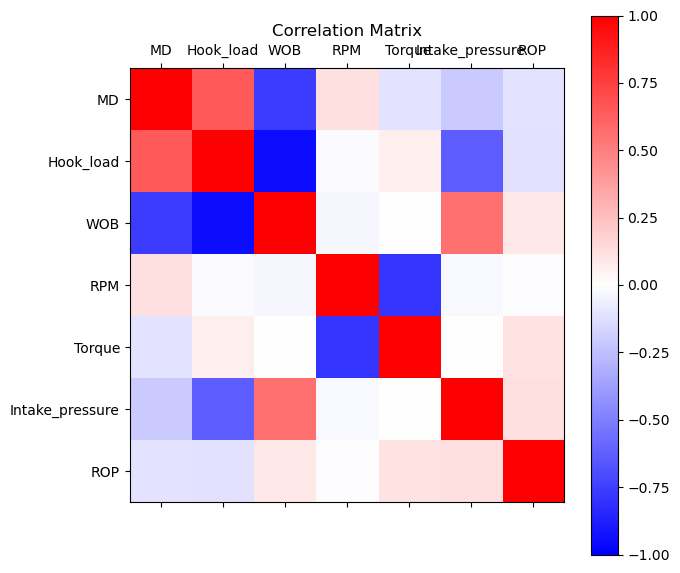

In [7]:
#Plot correlation matrix
plot_corr(drilling_data, size=7)
plt.show()

**Important note:**

* As it can be seen from correlation matrix, ROP has a low Pearson correlation coefficient with all predictor features. This indicates that there is a weak linear relationship between ROP and predictors. Thus, linear regression models are not suitable for this problem.

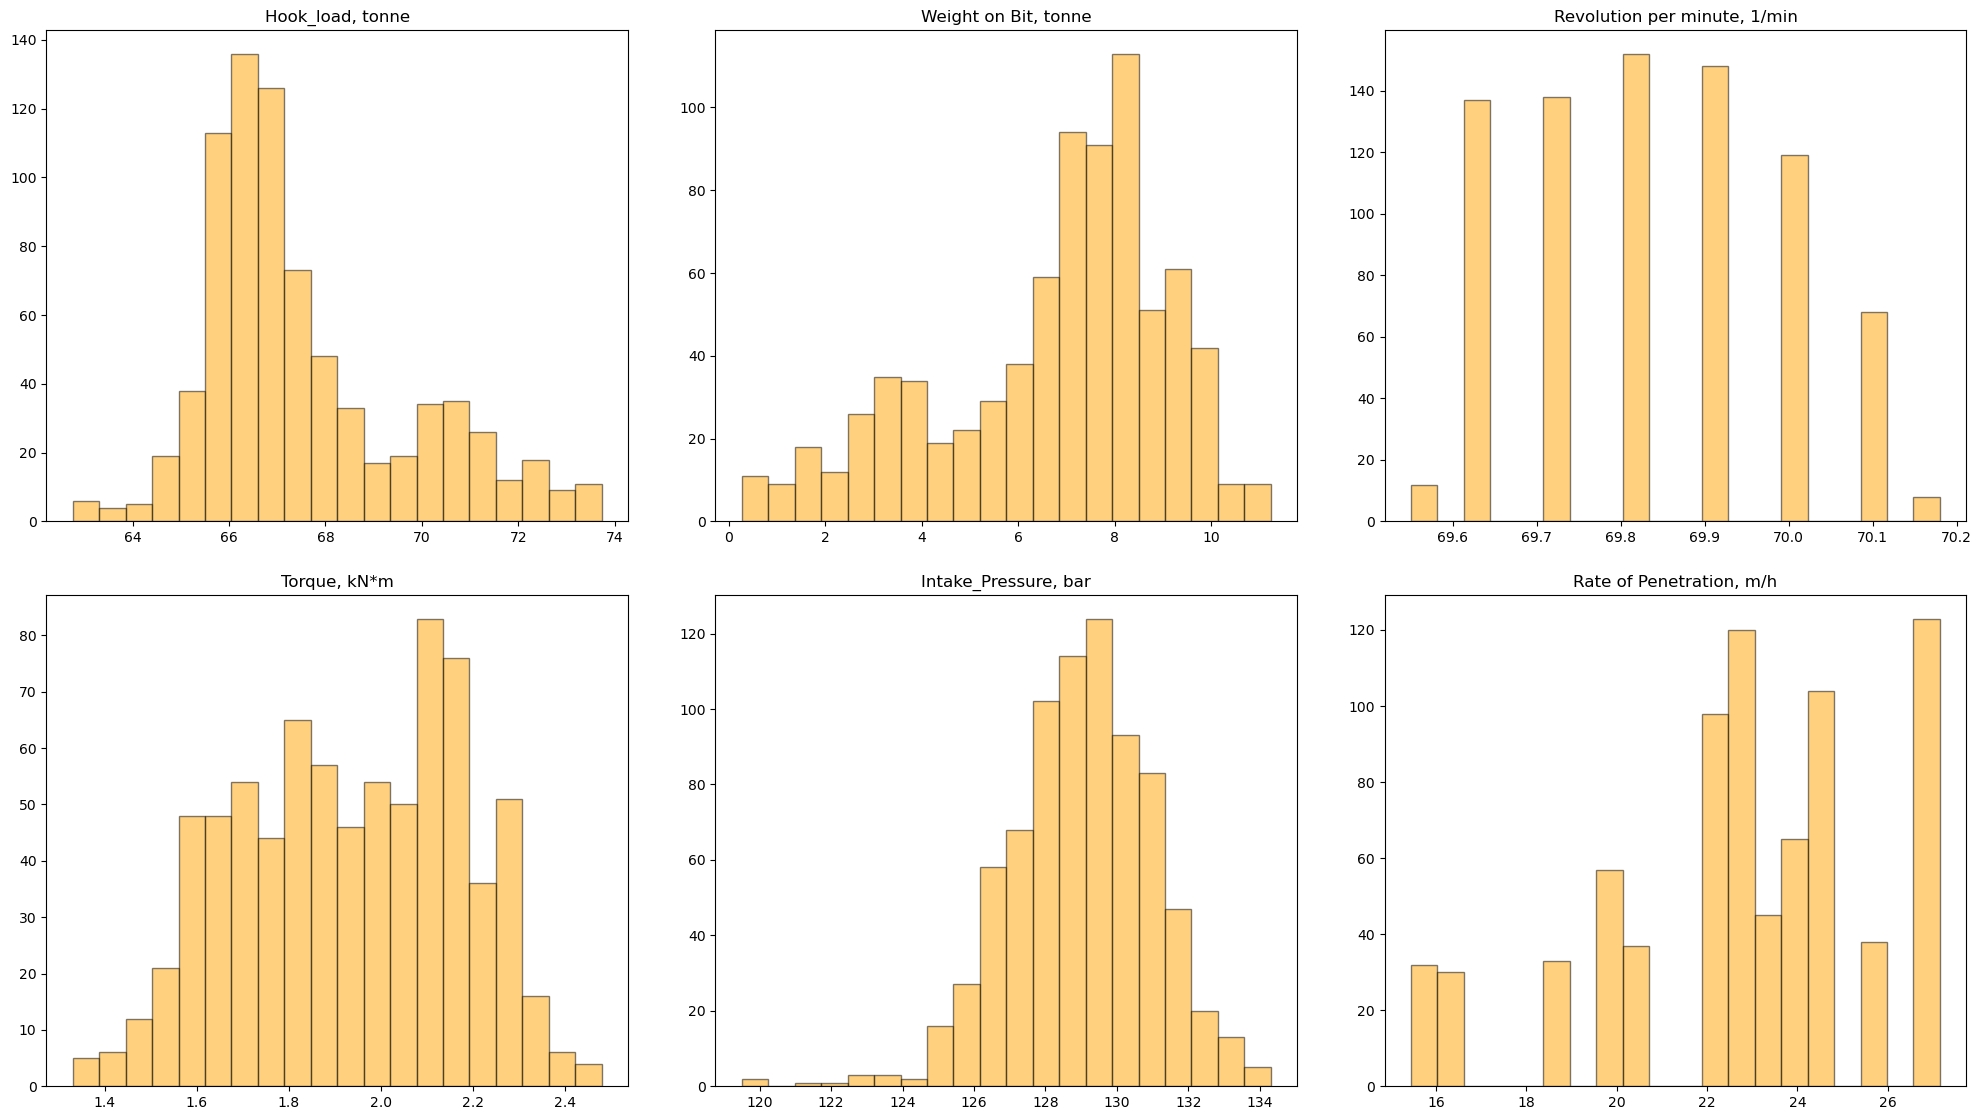

In [8]:
# Plot data distribution
features = ['Hook_load', 'WOB', 'RPM', 'Torque', 'Intake_pressure', 'ROP']
plot_data(drilling_data, features)

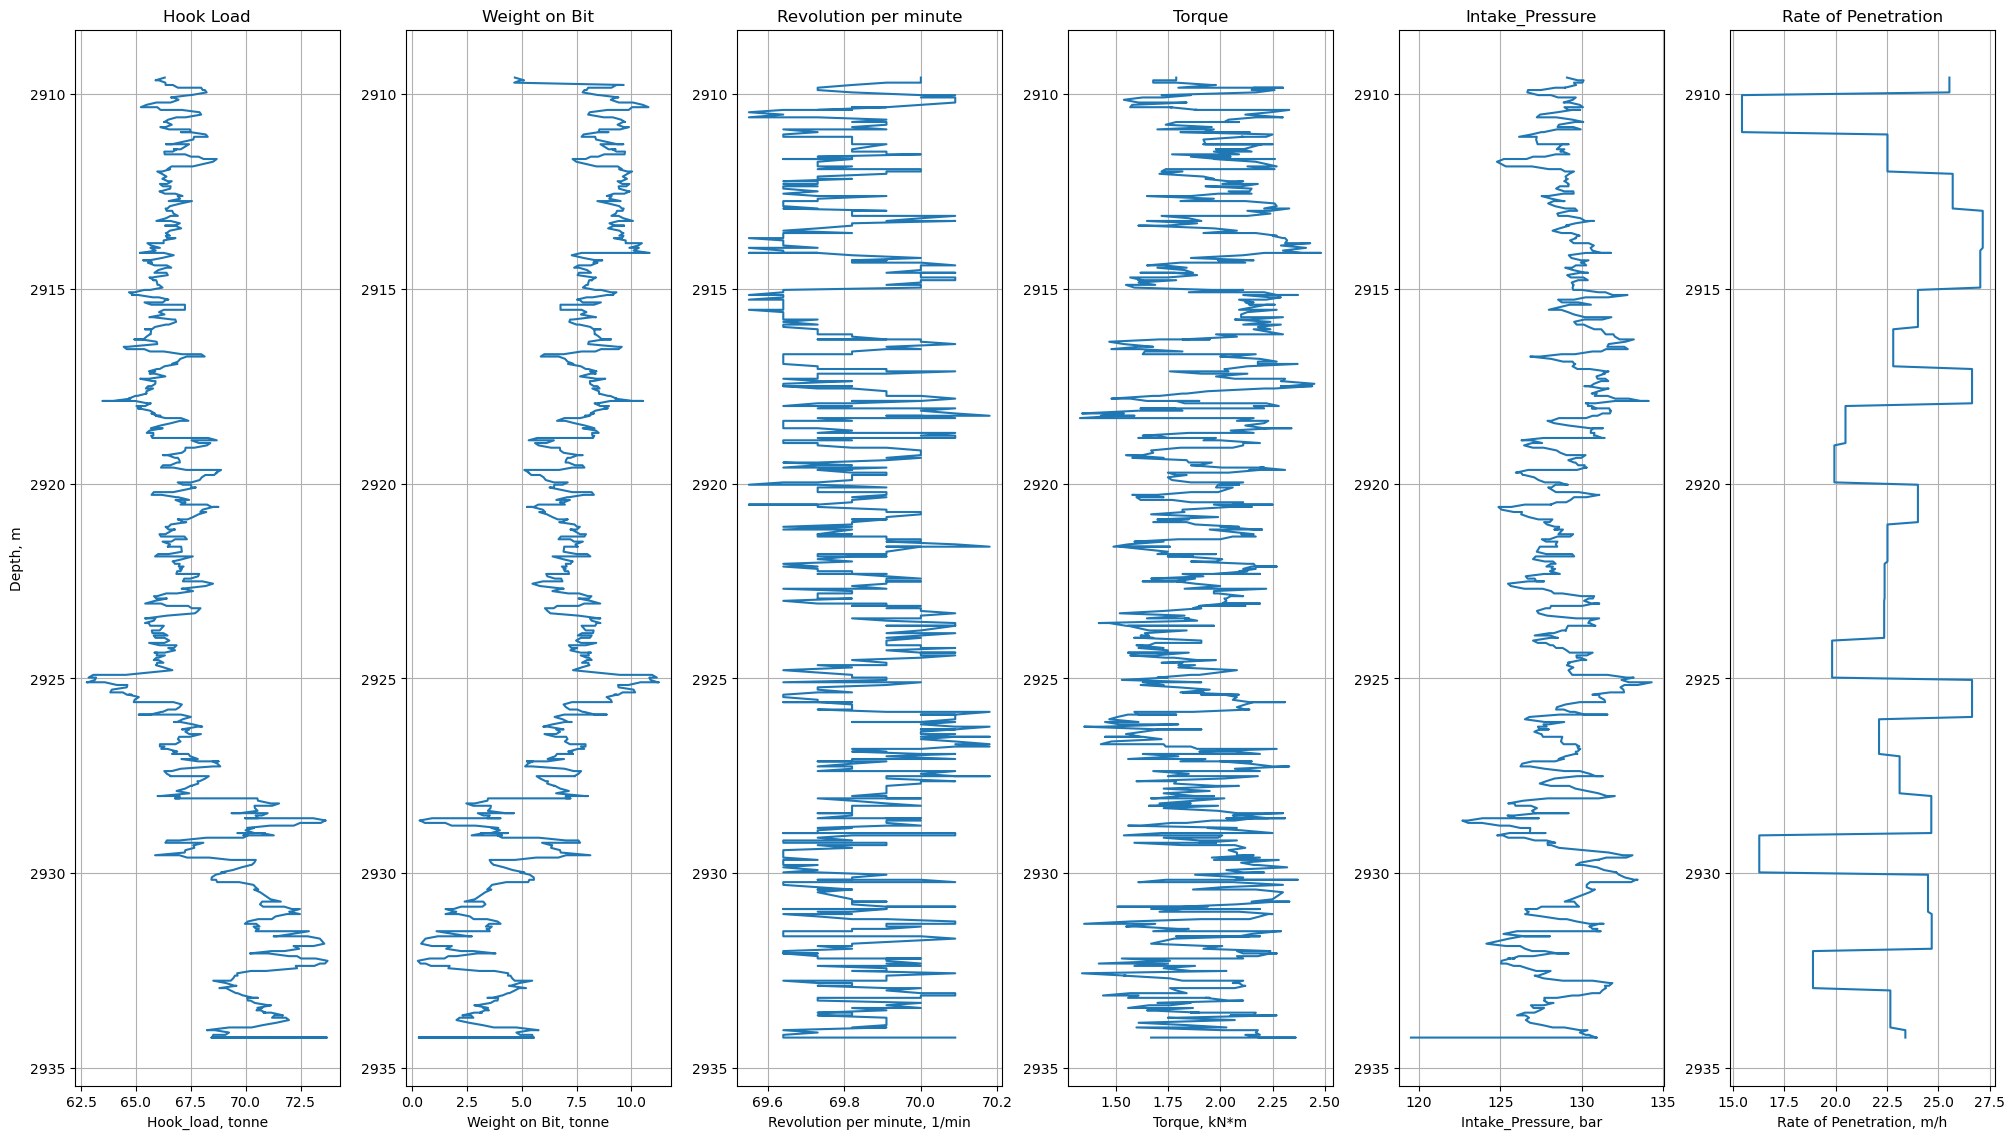

In [9]:
# EDR
plot_data_as_EDR(drilling_data, features)

### 3. Train test data split

We will use the following features as predictors:
* **Hook Load**
* **Weight on bit**
* **Revolution per minute**
* **Torque**
* **Intake pressure**



**Proposal for train test split:**
* Let's try two different data splits. **First - random, second - last 20% of the data for testing.**

In [10]:
# Random split

X_train1, X_test1, y_train1, y_test1 = train_test_split(drilling_data.iloc[:,[1,2,3,4,5]], 
                                                    drilling_data.iloc[:,6], 
                                                    test_size=0.20, random_state=73073)  # Train test split

X_train1.reset_index(drop=True, inplace=True)
X_test1.reset_index(drop=True, inplace=True)
y_train1 = pd.DataFrame(y_train1.values, columns=['ROP'])
y_test1 = pd.DataFrame(y_test1.values, columns=['ROP'])

In [11]:
# Last 20% for testing
train_precentage = 0.8

train_size = int(len(drilling_data) * train_precentage)
test_size = len(drilling_data) - train_size

X_train2, y_train2 = drilling_data.iloc[0:train_size,[1,2,3,4,5]], drilling_data.iloc[0:train_size,[6]]
X_test2 = drilling_data.iloc[train_size:len(drilling_data),[1,2,3,4,5]].reset_index(drop=True)
y_test2 = drilling_data.iloc[train_size:len(drilling_data),[6]].reset_index(drop=True)

# MD for testing data, in order to present results as EDR log
MD = drilling_data.iloc[train_size:len(drilling_data),[0]].reset_index(drop=True)

print(len(X_train2), len(y_test2))

625 157


### 4. Random Forest models

Random Forest is one of the most universal ML methods for regression, which works on bagging principle, constructing and averaging several realzation of Decision Trees.

This section of work is split into 3 parts, which are:
* **First RF model.** Training random forest model on a randomly split data.
* **Second RF model.** Build model using the second case of data split.
* **Random Forest Feature Importance**. Evaluation of the most important feature for both cases.

Hyperparameters tuning for this method is not required, so we will use n_estimators=100

#### 4.1 First RF model

In [12]:
# First Random Forest model
rf1, prediction1, MSE1, Var_Exp1, R21, corr1, error1, mean1, std1 = random_forest(X_train1, X_test1,
                                                                                 y_train1, y_test1)

Error standard deviation is 2.86 m/h
Mean squared error is 8.25
Coefficiant of determination is 0.136
Correlation coefficient is 0.369
Variance explained score is 0.143


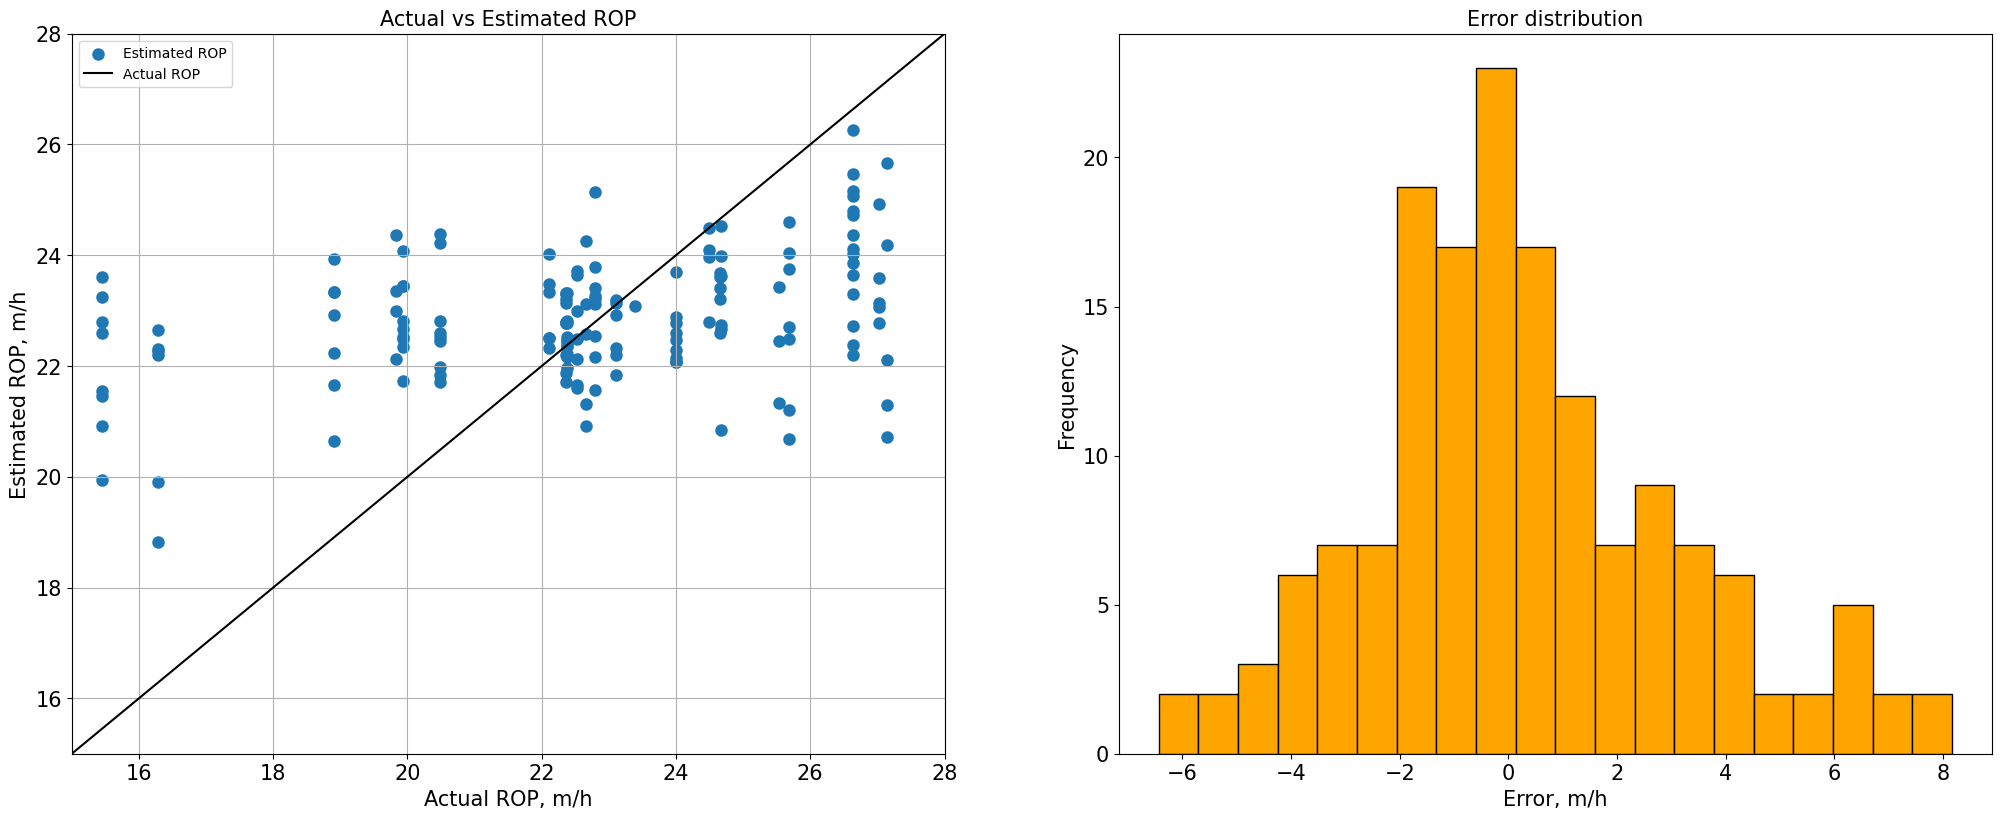

In [13]:
#Set parameters for plotting
y_test = y_test1.values.ravel()
pred = prediction1.ravel()
error = error1.ravel()

print('Error standard deviation is ' + str("{:.2f}".format(std1)) + ' m/h')
print('Mean squared error is ' + str("{:.2f}".format(MSE1)))
print('Coefficiant of determination is ' + str("{:.3f}".format(R21)))
print('Correlation coefficient is ' + str("{:.3f}".format(corr1)))
print('Variance explained score is ' + str("{:.3f}".format(Var_Exp1)))

plt.subplot(1,2,1)
plt.scatter(y_test, pred, linewidth=3, label='Estimated ROP')
plt.title('Actual vs Estimated ROP', fontsize=15); 
plt.ylabel('Estimated ROP, m/h', fontsize=15); plt.xlabel('Actual ROP, m/h', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15);
plt.xlim(15,28); plt.ylim(15,28); plt.plot([15,28],[15,28], c='k', label='Actual ROP')
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.hist(error, color='orange', edgecolor='black', bins=20)
plt.ylabel('Frequency', fontsize=15); plt.xlabel('Error, m/h', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15);
plt.title('Error distribution', fontsize=15)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

#### 4.2 Second RF model

In [14]:
# Second Random Forest model
rf2, prediction2, MSE2, Var_Exp2, R22, corr2, error2, mean2, std2 = random_forest(X_train2, X_test2,
                                                                                  y_train2, y_test2)

Error standard deviation is 2.94 m/h
Mean squared error is 11.91
Coefficiant of determination is -0.394
Correlation coefficient is -0.628
Variance explained score is -0.013


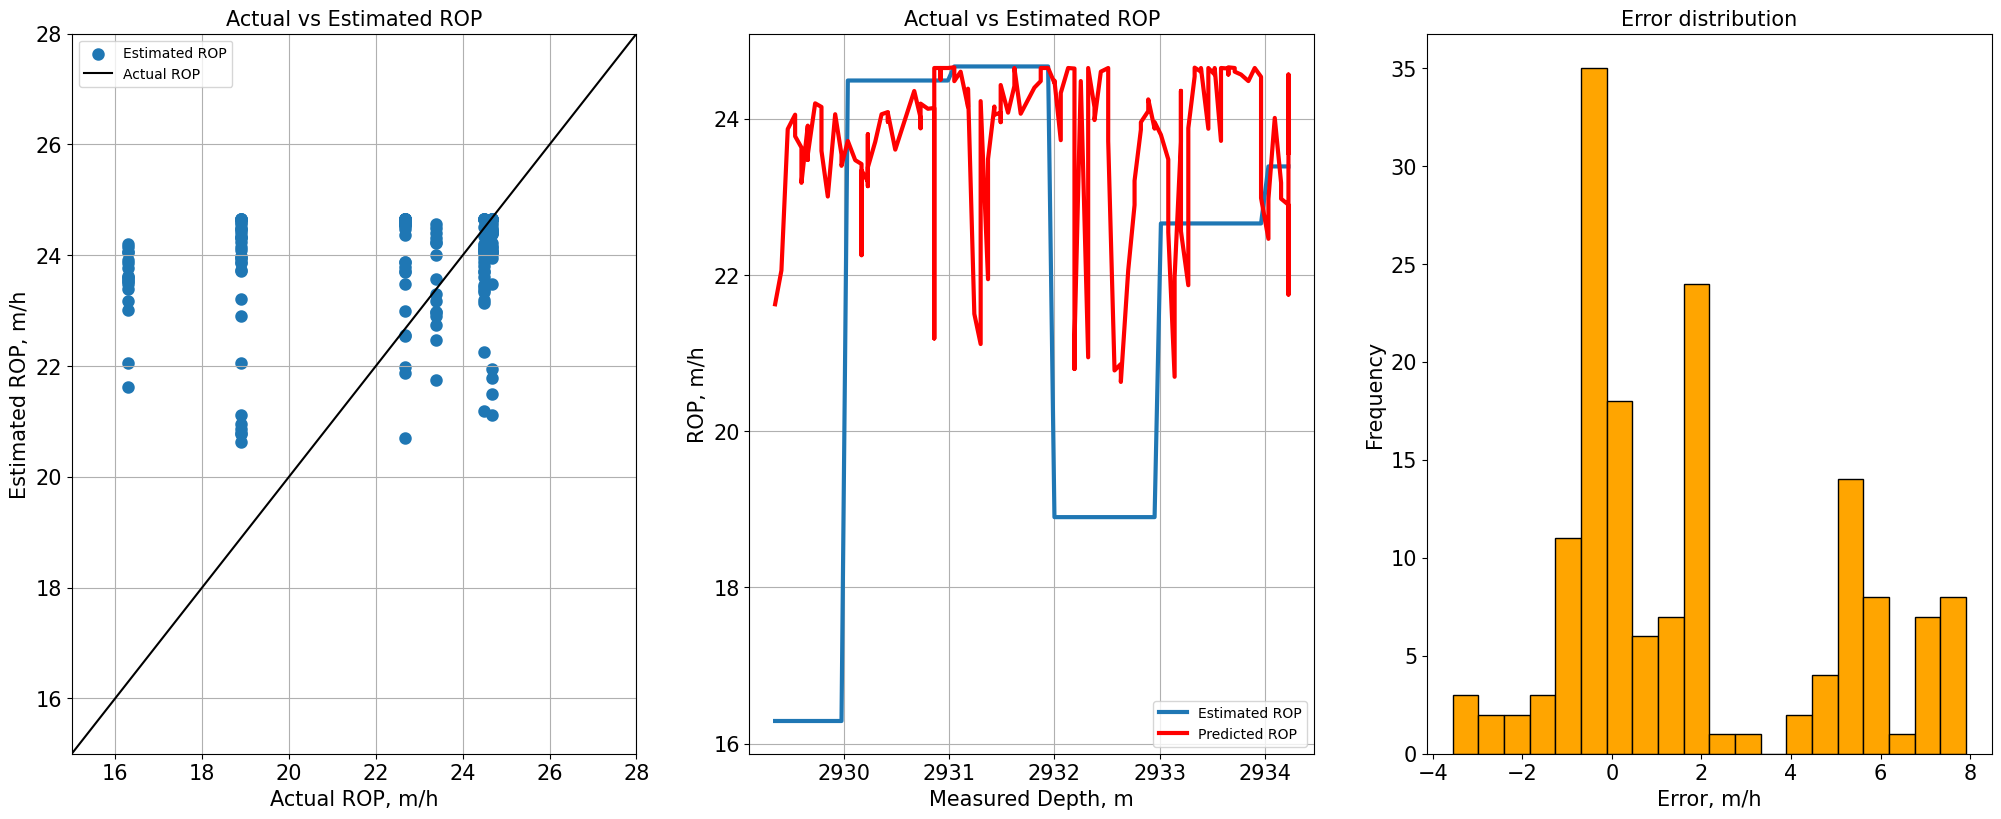

In [15]:
#Set parameters for plotting
y_test = y_test2.values.ravel()
pred = prediction2.ravel()
depth = MD.values.ravel()
error = error2.ravel()

print('Error standard deviation is ' + str("{:.2f}".format(std2)) + ' m/h')
print('Mean squared error is ' + str("{:.2f}".format(MSE2)))
print('Coefficiant of determination is ' + str("{:.3f}".format(R22)))
print('Correlation coefficient is ' + '-' + str("{:.3f}".format(corr2)))
print('Variance explained score is ' + str("{:.3f}".format(Var_Exp2)))

plt.subplot(1,3,1)
plt.scatter(y_test, pred, linewidth=3, label='Estimated ROP')
plt.title('Actual vs Estimated ROP', fontsize=15); 
plt.ylabel('Estimated ROP, m/h', fontsize=15); plt.xlabel('Actual ROP, m/h', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15);
plt.xlim(15,28); plt.ylim(15,28); plt.plot([15,28],[15,28], c='k', label='Actual ROP')
plt.legend(); plt.grid()

plt.subplot(1,3,2)
plt.plot(depth, y_test, linewidth=3, label='Estimated ROP')
plt.plot(depth, pred, linewidth=3, c='r', label='Predicted ROP')
plt.title('Actual vs Estimated ROP', fontsize=15); 
plt.ylabel('ROP, m/h', fontsize=15); plt.xlabel('Measured Depth, m', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15);
#plt.xlim(15,28); plt.ylim(15,28); plt.plot([15,28],[15,28], c='k', label='Actual ROP')
plt.legend(); plt.grid()
    
plt.subplot(1,3,3)
plt.hist(error, color='orange', edgecolor='black', bins=20)
plt.ylabel('Frequency', fontsize=15); plt.xlabel('Error, m/h', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15);
plt.title('Error distribution', fontsize=15)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

**Result comparison and interpretation**

* First case (random data split) gives better MSE score. Random split enables the model to tackle more possible depencancies between target and predictor features.
* Variance explained score is very low - this is because the actual variance of target ROP is not that big, as ROP patterns are mostly plateaus.

#### 4.3 Random Forest Feature Importance

The following code is taken from Professor Michael Pyrcz's workflow for [feature ranking](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb)

Feature ranking 1st model:
1. feature 4 (0.266597)
2. feature 1 (0.257387)
3. feature 3 (0.188648)
4. feature 0 (0.186638)
5. feature 2 (0.100730)
Feature ranking 2nd model:
1. feature 1 (0.285591)
2. feature 4 (0.273928)
3. feature 3 (0.178402)
4. feature 0 (0.170945)
5. feature 2 (0.091135)


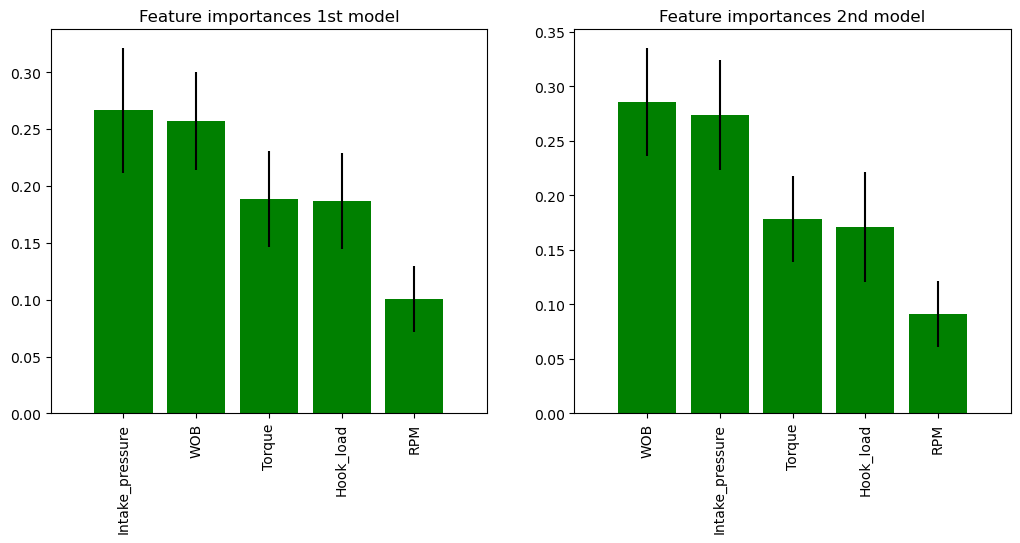

In [16]:
x1 = X_train1
x2 = X_train2

#Calculate importances
importances1 = rf1.feature_importances_     # extract the expected feature importances
std_1 = np.std([tree.feature_importances_ for tree in rf1.estimators_],axis=0) # calculate stdev over trees
indices1 = np.argsort(importances1)[::-1]   # find indicies for descending order
importances2 = rf2.feature_importances_     # extract the expected feature importances
std_2 = np.std([tree.feature_importances_ for tree in rf2.estimators_],axis=0) # calculate stdev over trees
indices2 = np.argsort(importances2)[::-1]   # find indicies for descending order


#Print importances
print("Feature ranking 1st model:")                 # write out the feature importances
for f in range(x1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices1[f], importances1[indices1[f]]))
print("Feature ranking 2nd model:")                 # write out the feature importances
for f in range(x2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices2[f], importances2[indices2[f]]))

    
#Plot feature importances
plt.subplot(121)                      
plt.title("Feature importances 1st model")
plt.bar(range(x1.shape[1]), importances1[indices1],
       color="g", yerr=std_1[indices1], align="center")
plt.xticks(range(x1.shape[1]), x1.columns[indices1],rotation=90)
plt.xlim([-1, x1.shape[1]])

plt.subplot(122)                      
plt.title("Feature importances 2nd model")
plt.bar(range(x2.shape[1]), importances2[indices2],
       color="g", yerr=std_2[indices2], align="center")
plt.xticks(range(x2.shape[1]), x2.columns[indices2],rotation=90)
plt.xlim([-1, x2.shape[1]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

**Observations:**

* As it can be seen, both models consider Intake Pressure and WOB to be the most important features for ROP prediction


* Interestingly that after random splitting the data, Intake Pressure feature actually has the highest impact, while taking last 20% of data for testing shows that WOB is getting more reliable feature for prediction. **This could indicate, if we are to forecast ROP, WOB would be the main feature which control ROP behavior - which is backed by physical processes that take place while drilling.**

### 5. Gradient Boosting Decision Tree models

Gradient Boosting is a bit more complex method than Random Forest. This method can be tuned to match the actual complexity of the problem. It utilizes boosting principle and build weak predictors (Decision trees in the given case) upon each other.

Overall, Gradient Boosting has higher variance and lower bias than Random Forest, which will hopefully increase model's accuracy.

This section of work is split into 4 parts, which are:
* **Hyperparameters tuning.** Reaching the optimum bias-variance trade-off point.
* **First GB model.** Training gradient boosting model on a randomly split data.
* **Second GB model.** Build model using the second case of data split.
* **Gradient Boosting Feature Importance**. Evaluation of the most important feature for both cases.

#### 5.1 Hyperparameters tuning

* Due to the fact that optimum hyperparameters were found to be almost the same for both data split cases, tuning process shown only for the first case.


Learning rate for Tree Depth tuning is set to 0.7

The following code is taken from Professor Michael Pyrcz's [Gradient Boosting](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Gradient_Boosting.ipynb) workflow

Complete of 100:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  100,  

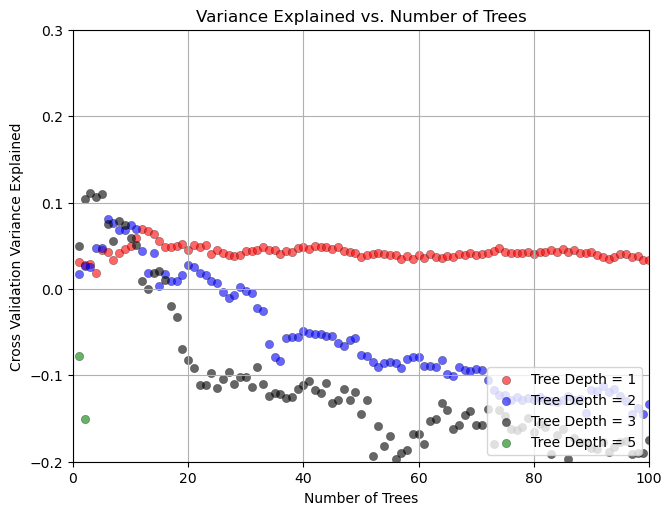

In [17]:
# Max depth - Number of trees tuning. Learning rate = 0.7
predictors = X_train1; predictors_test = X_test1
response = y_train1; response_test = y_test1

num_trees = np.linspace(1,100,100)
max_features = 1
boosting_models1 = []; boosting_models2 = []; boosting_models3 = []; boosting_models4 = []
score1 = []; score2 = []; score3 = []; score4 = [] 

params1 = {
    'loss': 'ls',                                      # L2 Norm - least squares
    'max_depth': 1,                                    # maximum depth per tree
    'learning_rate': 0.7,
    'criterion': 'mse'                                 # tree construction criteria is mean square error over training
}

params2 = {
    'loss': 'ls',                                      # L2 Norm - least squares
    'max_depth': 2,                                    # maximum depth per tree
    'learning_rate': 0.7,
    'criterion': 'mse'                                 # tree construction criteria is mean square error over training
}

params3 = {
    'loss': 'ls',                                      # L2 Norm - least squares
    'max_depth': 3,                                    # maximum depth per tree
    'learning_rate': 0.7,
    'criterion': 'mse'                                 # tree construction criteria is mean square error over training
}

params4 = {
    'loss': 'ls',                                      # L2 Norm - least squares
    'max_depth': 10,                                   # maximum depth per tree
    'learning_rate': 0.7,
    'criterion': 'mse'                                 # tree construction criteria is mean square error over training
}

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees in our random forest
    boosting_models1.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params1))
    boosting_models1[index-1].fit(X = predictors, y = response)
    score1.append(boosting_models1[index-1].score(X = predictors_test, y = response_test))
    
    boosting_models2.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params2))
    boosting_models2[index-1].fit(X = predictors, y = response)
    score2.append(boosting_models2[index-1].score(X = predictors_test, y = response_test)) 
    
    boosting_models3.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params3))
    boosting_models3[index-1].fit(X = predictors, y = response)
    score3.append(boosting_models3[index-1].score(X = predictors_test, y = response_test)) 
    
    boosting_models4.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params4))
    boosting_models4[index-1].fit(X = predictors, y = response)
    score4.append(boosting_models4[index-1].score(X = predictors_test, y = response_test)) 

    print(str(index)+ ', ', end =" ")
    index = index + 1
    
plt.subplot(111)                                            # plot jackknife results for all cases
plt.scatter(num_trees,score1,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6,
            linewidths=0.3, edgecolors="black", label = "Tree Depth = 1")
plt.scatter(num_trees,score2,s=None, c='blue', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6,
            linewidths=0.3, edgecolors="black", label = "Tree Depth = 2")
plt.scatter(num_trees,score3,s=None, c='black', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6,
            linewidths=0.3, edgecolors="black", label = "Tree Depth = 3")
plt.scatter(num_trees,score4,s=None, c='green', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6,
            linewidths=0.3, edgecolors="black", label = "Tree Depth = 5")

plt.title('Variance Explained vs. Number of Trees'); 
plt.xlabel('Number of Trees'); plt.ylabel('Cross Validation Variance Explained')
plt.xlim(0,100); plt.ylim(-0.2,0.3); plt.legend(loc='lower right'); plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
plt.show()

**Observations:**

* Model has a quite low Varience Explained score (In other words - high variance of error distribution). However, it can be seen that the model approaches the overfitting zone with Tree Depth > 3.
* Let's tune learning rate to get lower total error.

Complete of 100:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  100,  

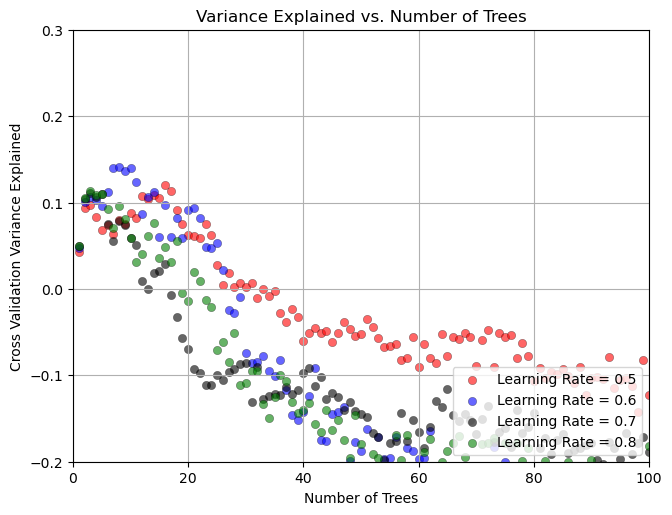

In [18]:
# Learning rate - Number of trees tuning. Max depth = 3
predictors = X_train1; predictors_test = X_test1
response = y_train1; response_test = y_test1

num_trees = np.linspace(1,100,100)
max_features = 1
boosting_models1 = []; boosting_models2 = []; boosting_models3 = []; boosting_models4 = []
score1 = []; score2 = []; score3 = []; score4 = [] 

params1 = {
    'loss': 'ls',                                     # L2 Norm - least squares
    'max_depth': 3,                                   # maximum depth per tree
    'learning_rate': 0.5,
    'criterion': 'mse'                                # tree construction criteria is mean square error over training
}

params2 = {
    'loss': 'ls',                                     # L2 Norm - least squares
    'max_depth': 3,                                   # maximum depth per tree
    'learning_rate': 0.6,
    'criterion': 'mse'                                # tree construction criteria is mean square error over training
}

params3 = {
    'loss': 'ls',                                     # L2 Norm - least squares
    'max_depth': 3,                                   # maximum depth per tree
    'learning_rate': 0.7,
    'criterion': 'mse'                                # tree construction criteria is mean square error over training
}

params4 = {
    'loss': 'ls',                                     # L2 Norm - least squares
    'max_depth': 3,                                   # maximum depth per tree
    'learning_rate': 0.8,
    'criterion': 'mse'                                # tree construction criteria is mean square error over training
}

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees in our random forest
    boosting_models1.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params1))
    boosting_models1[index-1].fit(X = predictors, y = response)
    score1.append(boosting_models1[index-1].score(X = predictors_test, y = response_test))
    
    boosting_models2.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params2))
    boosting_models2[index-1].fit(X = predictors, y = response)
    score2.append(boosting_models2[index-1].score(X = predictors_test, y = response_test)) 
    
    boosting_models3.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params3))
    boosting_models3[index-1].fit(X = predictors, y = response)
    score3.append(boosting_models3[index-1].score(X = predictors_test, y = response_test)) 
    
    boosting_models4.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params4))
    boosting_models4[index-1].fit(X = predictors, y = response)
    score4.append(boosting_models4[index-1].score(X = predictors_test, y = response_test)) 

    print(str(index)+ ', ', end =" ")
    index = index + 1
    
plt.subplot(111)                                            # plot jackknife results for all cases                                        
plt.scatter(num_trees,score1,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None,
            alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 0.5")
plt.scatter(num_trees,score2,s=None, c='blue', marker=None, cmap=None, norm=None, vmin=None, vmax=None,
            alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 0.6")
plt.scatter(num_trees,score3,s=None, c='black', marker=None, cmap=None, norm=None, vmin=None, vmax=None,
            alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 0.7")
plt.scatter(num_trees,score4,s=None, c='green', marker=None, cmap=None, norm=None, vmin=None, vmax=None,
            alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 0.8")

plt.title('Variance Explained vs. Number of Trees'); 
plt.xlabel('Number of Trees'); plt.ylabel('Cross Validation Variance Explained')
plt.xlim(0,100); plt.ylim(-0.2,0.3); plt.legend(loc='lower right'); plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
plt.show()

**Observations:**

* Reducing learning rate to 0.6 improves variance explained score.
* Optimal hyperparameters were found to be: Tree Depth = 3; Learning rate = 0.6; Num Trees = 10.
* The model approaches the overfitting zone quite fast and increasing model's complexity doesn't give much of improvement.

#### 5.2 First GB model

In [19]:
# First Gradient Boosting model
boosting1, prediction1, MSE1, Var_Exp1, R21, corr1, error1, mean1, std1 = boosting(X_train1, X_test1,
                                                                                  y_train1, y_test1, max_depth=3,
                                                                                    learning_rate=0.6, num_tree = 10)

Error standard deviation is 2.86 m/h
Mean squared error is 8.21
Coefficiant of determination is 0.140
Correlation coefficient is 0.375
Variance explained score is 0.145


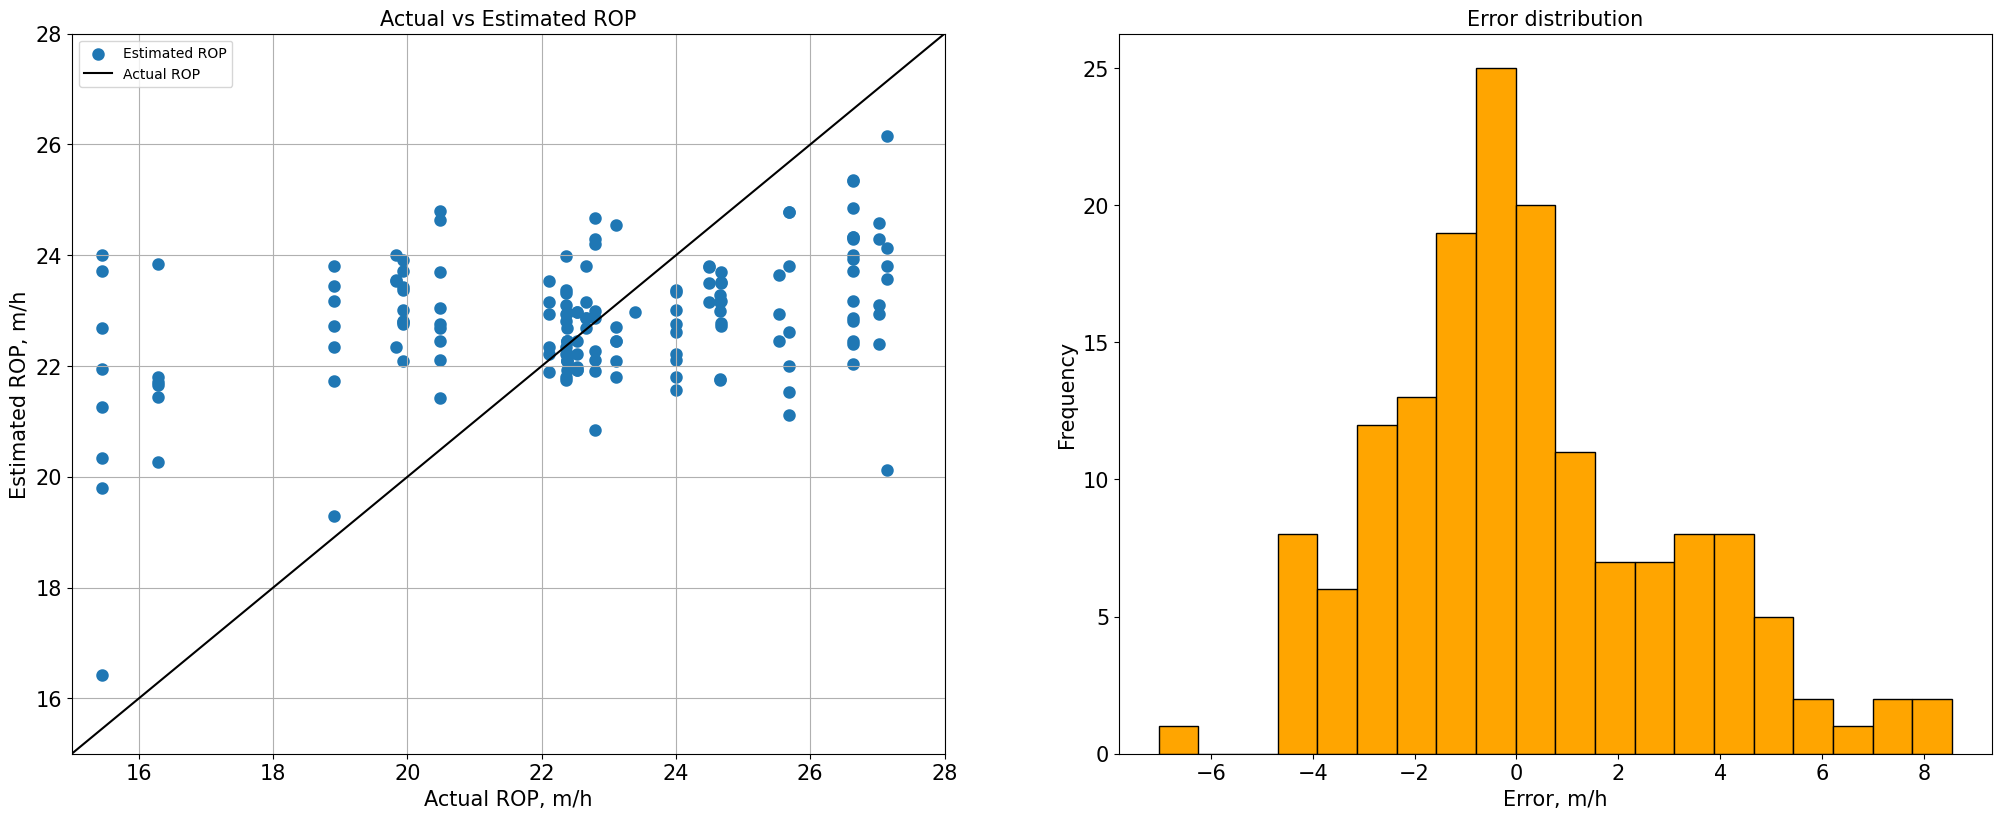

In [20]:
#Set parameters for plotting
y_test = y_test1.values.ravel()
pred = prediction1.ravel()
error = error1.ravel()

print('Error standard deviation is ' + str("{:.2f}".format(std1)) + ' m/h')
print('Mean squared error is ' + str("{:.2f}".format(MSE1)))
print('Coefficiant of determination is ' + str("{:.3f}".format(R21)))
print('Correlation coefficient is ' + str("{:.3f}".format(corr1)))
print('Variance explained score is ' + str("{:.3f}".format(Var_Exp1)))

plt.subplot(1,2,1)
plt.scatter(y_test, pred, linewidth=3, label='Estimated ROP')
plt.title('Actual vs Estimated ROP', fontsize=15); 
plt.ylabel('Estimated ROP, m/h', fontsize=15); plt.xlabel('Actual ROP, m/h', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15);
plt.xlim(15,28); plt.ylim(15,28); plt.plot([15,28],[15,28], c='k', label='Actual ROP')
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.hist(error, color='orange', edgecolor='black', bins=20)
plt.ylabel('Frequency', fontsize=15); plt.xlabel('Error, m/h', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15);
plt.title('Error distribution', fontsize=15)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

#### 5.3 Second GB model

In [21]:
boosting2, prediction2, MSE2, Var_Exp2, R22, corr2, error2, mean2, std2 = boosting(X_train2, X_test2,
                                                                                  y_train2, y_test2, max_depth=3,
                                                                                    learning_rate=0.6, num_tree = 10)

Error standard deviation is 2.89 m/h
Mean squared error is 13.34
Coefficiant of determination is -0.562
Correlation coefficient is -0.749
Variance explained score is 0.022


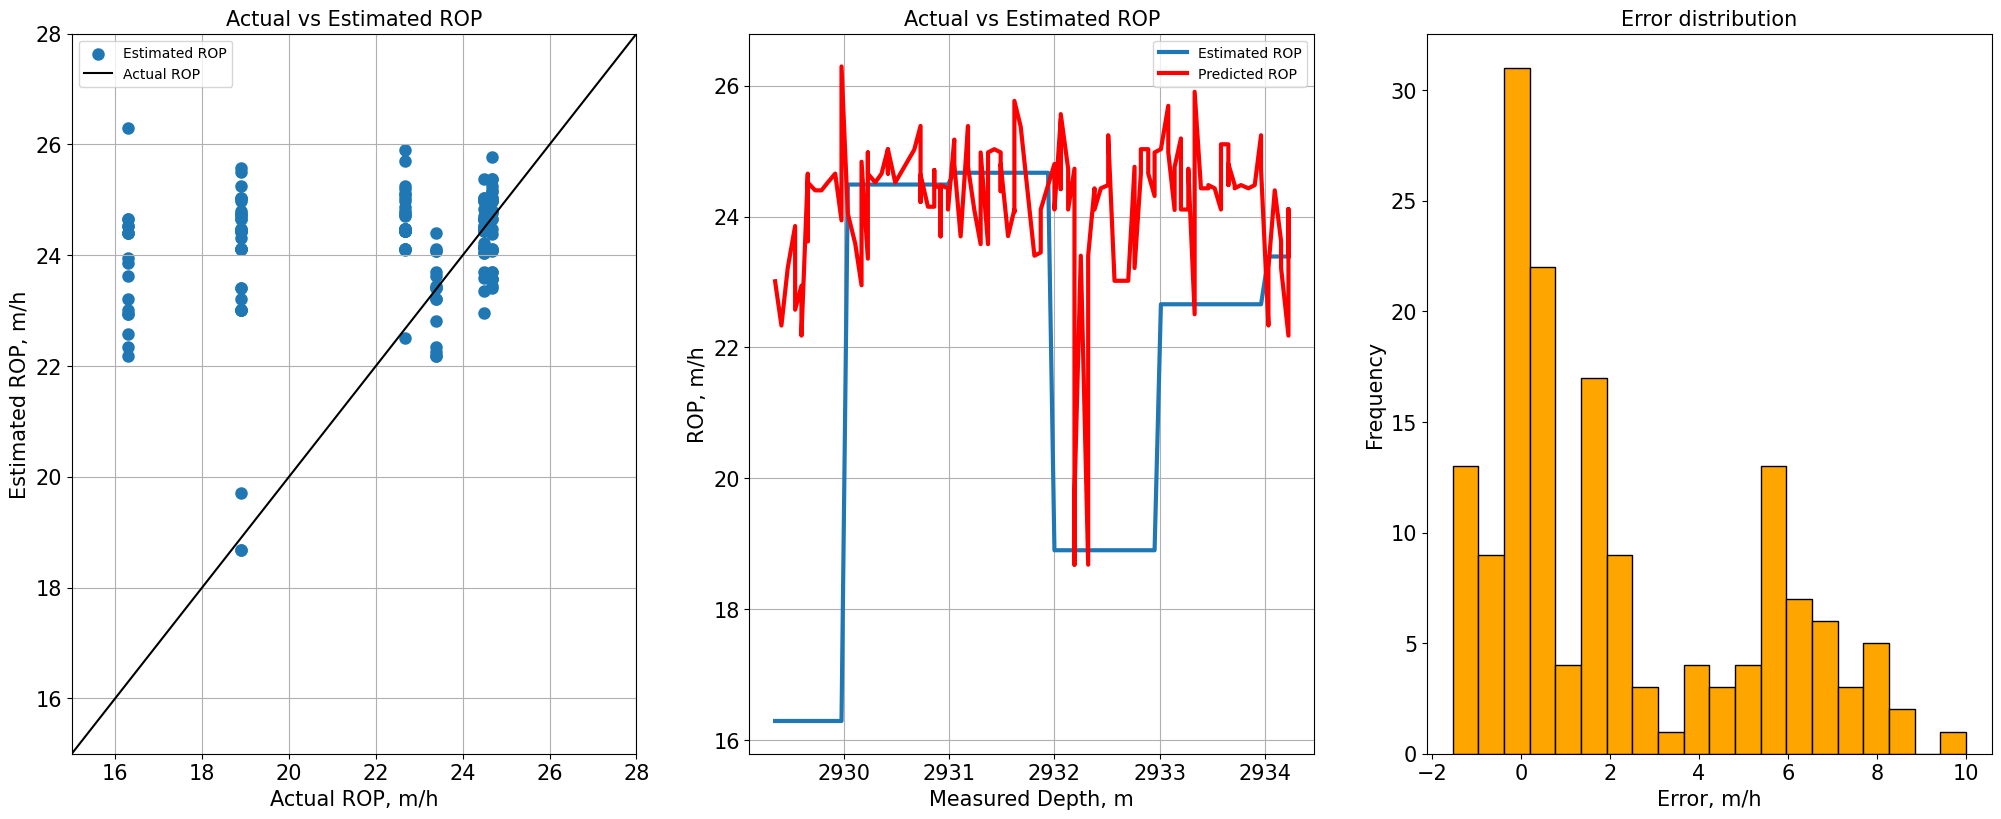

In [22]:
#Set parameters for plotting
y_test = y_test2.values.ravel()
pred = prediction2.ravel()
depth = MD.values.ravel()
error = error2.ravel()

print('Error standard deviation is ' + str("{:.2f}".format(std2)) + ' m/h')
print('Mean squared error is ' + str("{:.2f}".format(MSE2)))
print('Coefficiant of determination is ' + str("{:.3f}".format(R22)))
print('Correlation coefficient is ' + '-'+str("{:.3f}".format(corr2)))
print('Variance explained score is ' + str("{:.3f}".format(Var_Exp2)))

plt.subplot(1,3,1)
plt.scatter(y_test, pred, linewidth=3, label='Estimated ROP')
plt.title('Actual vs Estimated ROP', fontsize=15); 
plt.ylabel('Estimated ROP, m/h', fontsize=15); plt.xlabel('Actual ROP, m/h', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15);
plt.xlim(15,28); plt.ylim(15,28); plt.plot([15,28],[15,28], c='k', label='Actual ROP')
plt.legend(); plt.grid()

plt.subplot(1,3,2)
plt.plot(depth, y_test, linewidth=3, label='Estimated ROP')
plt.plot(depth, pred, linewidth=3, c='r', label='Predicted ROP')
plt.title('Actual vs Estimated ROP', fontsize=15); 
plt.ylabel('ROP, m/h', fontsize=15); plt.xlabel('Measured Depth, m', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15);
#plt.xlim(15,28); plt.ylim(15,28); plt.plot([15,28],[15,28], c='k', label='Actual ROP')
plt.legend(); plt.grid()
    
plt.subplot(1,3,3)
plt.hist(error, color='orange', edgecolor='black', bins=20)
plt.ylabel('Frequency', fontsize=15); plt.xlabel('Error, m/h', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15);
plt.title('Error distribution', fontsize=15)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

**Result comparison and interpretation**

* Results are almost the same as for Random Forest models.
* First GB model gives the best prediction MSE score, which means that the more complex method did improve the accuracy.
* However, EDR data is not enough to predict ROP

#### 5.4 Gradient Boosting Feature Importance

The following code is taken from Professor Michael Pyrcz's workflow for [feature ranking](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb)

Feature ranking 1st model:
1. feature 1 (0.305403)
2. feature 4 (0.276736)
3. feature 0 (0.180028)
4. feature 3 (0.177151)
5. feature 2 (0.060682)
Feature ranking 2nd model:
1. feature 1 (0.341896)
2. feature 4 (0.273637)
3. feature 3 (0.165409)
4. feature 0 (0.152797)
5. feature 2 (0.066261)


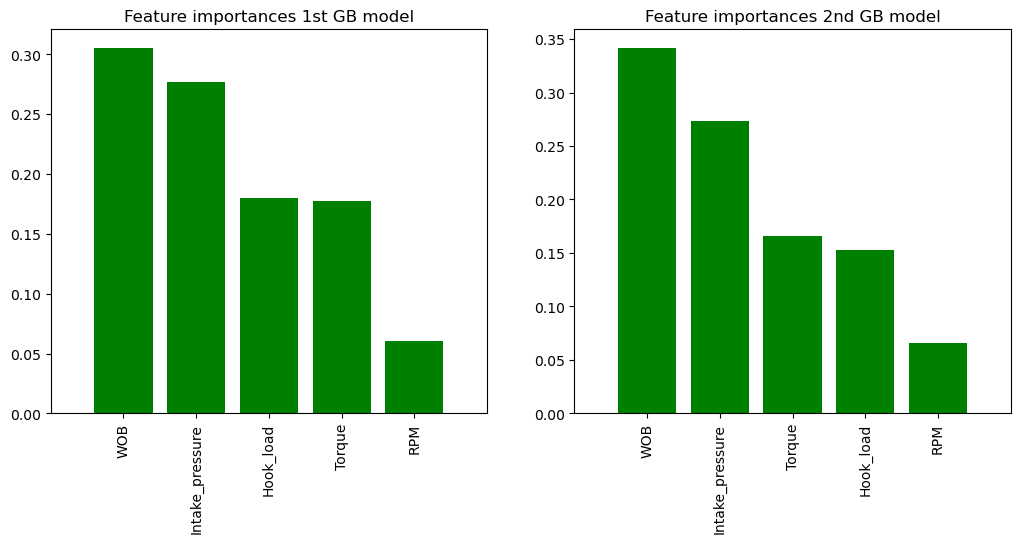

In [23]:
x1 = X_train1
x2 = X_train2

#Calculate feature importances
importances1 = boosting1.feature_importances_     # extract the expected feature importances
indices1 = np.argsort(importances1)[::-1]   # find indicies for descending order
importances2 = boosting2.feature_importances_     # extract the expected feature importances
indices2 = np.argsort(importances2)[::-1]   # find indicies for descending order

#Print feature importances
print("Feature ranking 1st model:")                 # write out the feature importances
for f in range(x1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices1[f], importances1[indices1[f]]))
print("Feature ranking 2nd model:")                 # write out the feature importances
for f in range(x1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices2[f], importances2[indices2[f]]))

    
#Plot feature importances
plt.subplot(121)                          # plot the feature importance 
plt.title("Feature importances 1st GB model")
plt.bar(range(x1.shape[1]), importances1[indices1],
       color="g", align="center")
plt.xticks(range(x1.shape[1]), x1.columns[indices1],rotation=90)
plt.xlim([-1, x1.shape[1]])

plt.subplot(122)                          # plot the feature importance 
plt.title("Feature importances 2nd GB model")
plt.bar(range(x2.shape[1]), importances2[indices2],
       color="g", align="center")
plt.xticks(range(x2.shape[1]), x2.columns[indices2],rotation=90)
plt.xlim([-1, x2.shape[1]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

**Observations:**

* Feature importance's for both case are almost the same as for Random Forest models
* Intake pressure and WOB are two most important features for ROP from EDR data

### Results

* **1.** There is **no linear relationship** between target ROP feature and drilling regime predictor features


* **2.** It was found out that **Standpipe pressure and WOB have the highest impact on ROP prediction.** And this is actually very good insight, which is confirmed by many field practical observations.


* **3.** Gradient boosting with the random split of data gave the best prediction. Presumably, the model learns more possible combinations between target and predictors while randomly splitting data.


* **4.** **EDR data is not enough to predict ROP.** More complex models (Gradient Boosting) didn't give much of improvement.


* **5.** Overall, MSE score is quite good, however, models cannot understand what drives the change in ROP.



### Suggestions

* **1.** It is believed that more sources of data required to predict ROP. For example mud logging can transmit information on the rock compressive strength to the model, while GR can give the model information on what rock type is being drilling at the moment.


* **2.** Time-series forecasting could be applied to predict ROP and well construction performance.

Thank you for visiting, if you have any futher questions, please do not hesitate to reach out to me at Eldar.Sharafutdinov@utexas.edu. After being about 10 years in industry, particullary in drilling operations, I've decided to deep into the research. Subsurface Machine Learning course taught by Michael Pyrcz allowed me to gain essential knowledges and new expertise. 

I hope this was helpful,

Eldar Sharafutdinov

____________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
